# 2D Advection-Diffusion equation

in this notebook we provide a simple example of the DeepMoD algorithm and apply it on the 2D advection-diffusion equation. 

In [1]:
# Generalimports
import numpy as np
import torch

# DeepMoD functions

from deepymod import DeepMoD
from deepymod.model.func_approx import NN, Siren
from deepymod.model.library import Library2D_third
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold,PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from deepymod.analysis import load_tensorboard
from scipy.io import loadmat

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2


In [14]:
df = load_tensorboard('runs/figure_4')

In [23]:
df = load_tensorboard('runs/figure_5')

In [3]:
df.head()

,loss_loss,remaining_MSE_test,unscaled_coeffs_output_0_coeff_9,estimator_coeffs_output_0_coeff_8,estimator_coeffs_output_0_coeff_2,unscaled_coeffs_output_0_coeff_11,unscaled_coeffs_output_0_coeff_10,coeffs_output_0_coeff_5,coeffs_output_0_coeff_11,estimator_coeffs_output_0_coeff_0,...,estimator_coeffs_output_0_coeff_10,coeffs_output_0_coeff_1,unscaled_coeffs_output_0_coeff_7,estimator_coeffs_output_0_coeff_1,coeffs_output_0_coeff_0,coeffs_output_0_coeff_6,estimator_coeffs_output_0_coeff_6,coeffs_output_0_coeff_9,unscaled_coeffs_output_0_coeff_8,coeffs_output_0_coeff_2
0,0.128409,0.105241,87.670959,-0.201631,0.000000,-95.111168,130.347183,0.085840,-0.077831,0.583039,...,0.000000,0.047616,-0.266084,-0.437865,0.984411,-0.574629,-0.164783,0.144204,-7.135451,0.026575
25,0.051672,0.052413,-23.036959,-1.335327,-0.929022,-1.159716,4.803224,8.926932,-0.195851,2.021521,...,0.000000,-7.351344,1.409039,0.000000,3.606901,-4.637857,0.319815,-4.412689,-2.751643,3.264861
50,0.046267,0.044517,97.252991,-1.968360,-0.508572,32.820789,14.221384,-54.439938,15.881592,3.027259,...,-1.012613,28.127052,-13.435001,0.815271,-36.336025,-16.693981,0.000000,24.900846,-17.302553,6.819017
75,0.040375,0.040166,14.523050,-0.844256,0.000000,8.597620,-3.959001,-22.673363,11.787436,0.767041,...,-0.580820,12.421128,-5.734760,1.138450,-26.143724,-5.086850,0.000000,8.852604,-10.676355,3.194613
100,0.033792,0.034002,1.557177,-0.210821,0.149288,-0.186474,6.632484,-2.325138,-0.225515,0.000000,...,-0.468581,-0.277294,0.740117,0.732987,-0.461848,-9.032340,0.000000,0.653413,-2.139088,2.702749


(0.002, 0.01)

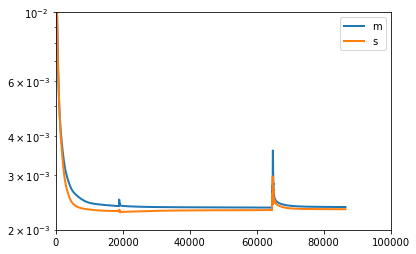

In [46]:
plt.plot(df['loss_loss'],linewidth=2)
plt.legend('total loss')

plt.plot(df['remaining_MSE_test'],linewidth=2)
plt.legend('mse test set')
plt.yscale('log')

plt.xlim(0,100000)
plt.ylim(0.002,0.01)

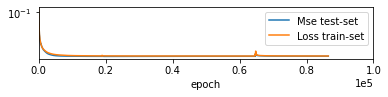

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df['remaining_MSE_test'])
ax.plot(df['loss_loss'])
ax.legend(['Mse test-set','Loss train-set'])
ax.set_xlabel('epoch')
ax.set_yscale('log')
ax.set_aspect(8000)
ax.set_xlim([0, 100000])
ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
fig.savefig('loss.pdf')

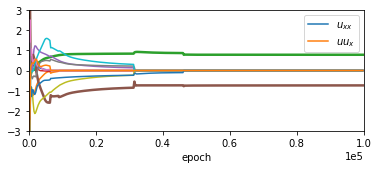

In [5]:
k = 40000
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df['coeffs_output_0_coeff_0'][:k:10])
ax.plot(df['coeffs_output_0_coeff_1'][:k:10])
ax.plot(df['coeffs_output_0_coeff_2'][:k:10],linewidth=2.5)
ax.plot(df['coeffs_output_0_coeff_3'][:k:10])
ax.plot(df['coeffs_output_0_coeff_4'][:k:10])
ax.plot(df['coeffs_output_0_coeff_5'][:k:10],linewidth=2.5)
ax.plot(df['coeffs_output_0_coeff_6'][:k:10])
ax.plot(df['coeffs_output_0_coeff_7'][:k:10])
ax.plot(df['coeffs_output_0_coeff_8'][:k:10])
ax.plot(df['coeffs_output_0_coeff_9'][:k:10])
ax.plot(df['coeffs_output_0_coeff_10'][:k:10])
ax.plot(df['coeffs_output_0_coeff_11'][:k:10])
ax.set_xlabel('epoch')
ax.set_ylim(-3,3)
ax.set_aspect(6000)
ax.legend(['$u_{xx}$','$u u_x$'])
ax.ticklabel_format(axis='x', style='sci', scilimits=[0, 0])
ax.set_xlim([0, 100000])
ax.set_ylim(-3,3)
fig.savefig('coeffs.pdf')

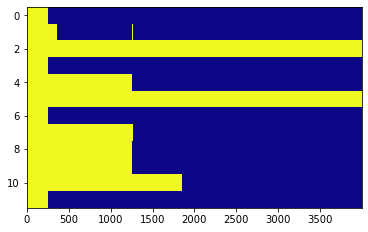

In [180]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(xi_plot,aspect=200, vmin=0, vmax=0.1,cmap='plasma', interpolation='none')
plt.savefig('mask.pdf')

In [26]:
xi = np.abs(np.array([df.loc[:,'coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,12)]))


In [27]:
xi_real = np.array([df.loc[:,'coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,12)])

In [28]:
xi[xi > 0.00001] = 1

In [29]:
xi_plot = xi[:,0:4000:1]

([<matplotlib.axis.XTick at 0x7fae78ef8790>,
 [Text(0, 0, '0'),
  Text(0, 0, '25000'),
  Text(0, 0, '50000'),
  Text(0, 0, '75000'),
  Text(0, 0, '100000')])

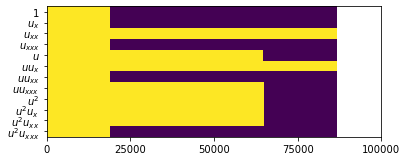

In [30]:
plt.imshow(xi_plot,aspect=130, vmin=0, vmax=1, interpolation='none')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11],['1','$u_x$','$u_{xx}$','$u_{xxx}$','$u$','$u u_x$','$u u_{xx}$','$u u_{xxx}$','$u^2$','$u^2 u_x$','$u^2 u_{xx}$','$u^2 u_{xxx}$'])
plt.xticks([0,1000,2000,3000,4000],[0,25000,50000,75000,100000])
#plt.savefig('mask.pdf')


In [119]:
xr = np.linspace(0,100000,40000)

In [120]:
xr.shape

(40000,)

<Figure size 432x288 with 0 Axes>

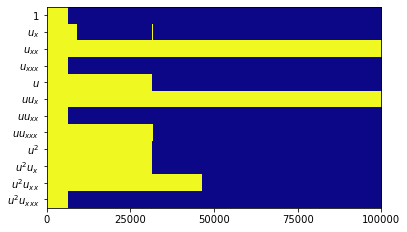

<Figure size 432x288 with 0 Axes>

In [182]:
np.nonzero(xi[:,0:65000:10])[0]

array([ 0,  0,  0, ..., 10, 10, 10])

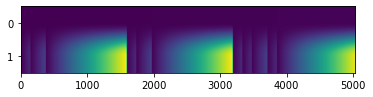

In [178]:
plt.imshow(np.nonzero(xi[:,0:65000:2]),aspect=0)

(10, 6000)

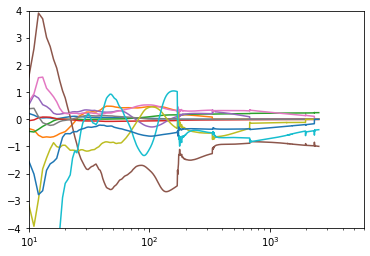

In [132]:
plt.semilogx(xi.T)
plt.ylim(-4,4)
plt.xlim(10,6000)

In [ ]:
xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
xi = np.append(xi,0)

## Noise dependency

In [12]:
mask = np.array([False,False,True,True,True,False,False,False,False,False])

In [13]:
ref = np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0,0,0,0,0]) + 10**-9*np.ones(10)

In [8]:
a = [0.01,0.02,0.05,0.1,0.15,0.2,0.3,0.5,0.75,1,1.5,2,3,4][::-1]


In [14]:
data_loop = a
error_noise = []
xi_list = []
for idx in data_loop:
    df = load_tensorboard('final_runs/Noise_runs/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    xi = np.append(xi,0)
    
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        xi_list.append(xi/ref_b)
        error_noise.append(1) 
    else:
        error_noise.append(0); 
        xi_list.append(np.nan_to_num(xi/xi))
        print('wrong')

<ipython-input-14-5fd1eb96cc82>:15: RuntimeWarning: invalid value encountered in true_divide
  xi_list.append(np.nan_to_num(xi/xi))


wrong
wrong
wrong
wrong
wrong
correct
correct
correct
correct
correct
correct
correct
correct
correct


In [23]:
data_loop = a
error_noise = []
xi_list = []
for idx in data_loop:
    df = load_tensorboard('final_runs/Noise_runs/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    xi = np.append(xi,0)
    
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        xi_list.append(xi.astype(bool))
        error_noise.append(1) 
    else:
        error_noise.append(0); 
        xi_list.append(xi.astype(bool))
        print('wrong')

wrong
wrong
wrong
wrong
wrong
correct
correct
correct
correct
correct
correct
correct
correct
correct


In [22]:
xi.astype(bool)

array([False, False,  True,  True,  True, False, False, False, False,
       False])

In [21]:
error_noise

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]

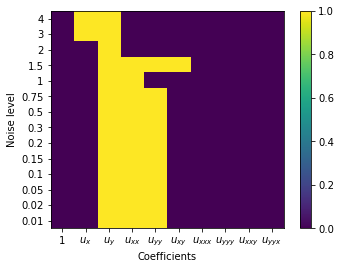

In [28]:
plt.imshow(np.array(xi_list).reshape(-1,10),vmin=0,vmax=1,aspect=1/1.5)
plt.colorbar()
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13],data_loop)
plt.xticks([0,1,2,3,4,5,6,7,8,9],['1','$u_x$','$u_y$','$u_{xx}$','$u_{yy}$','$u_{xy}$','$u_{xxx}$','$u_{yyy}$','$u_{xxy}$','$u_{yyx}$'])
plt.xlabel('Coefficients')
plt.ylabel('Noise level')
plt.savefig('noise.pdf')

Text(0, 0.5, 'Noise level')

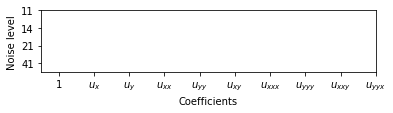

In [50]:

plt.imshow(np.array(xi_list).reshape(-1,9),vmin=0,vmax=0.25,aspect=1/2)
plt.yticks([0,1,2,3],['41', '21', '14', '11'])
plt.xticks([0,1,2,3,4,5,6,7,8,9],['1','$u_x$','$u_y$','$u_{xx}$','$u_{yy}$','$u_{xy}$','$u_{xxx}$','$u_{yyy}$','$u_{xxy}$','$u_{yyx}$'])
plt.xlabel('Coefficients')
plt.ylabel('Noise level')
#plt.savefig('no_noise_artificial.pdf')

In [9]:
data_loop = [0.01,0.02,0.05,0.1,0.15]
error_noise = []
for idx in data_loop:
    df = load_tensorboard('final_runs/Noise_runs_11_11_14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_noise.append(1) 
    else:
        error_noise.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong
wrong


## Spatial and temporal 

In [4]:
mask = np.array([False,False,True,True,True,False,False,False,False])

In [5]:
ref = np.array([0,0,0.2,0.02,0.02,0,0,0,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0,0,0,0]) + 10**-9*np.ones(9)

In [23]:
data_loop = [3,4,5,6,7,11,21,41]
error_7 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/no_noise_x7/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_7.append(1) 
    else:
        error_7.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong
wrong
wrong
wrong
wrong


In [22]:
data_loop = [3,4,5,6,7,11,21,41]
error_9 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/no_noise_x9/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_9.append(1) 
    else:
        error_9.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong
wrong
wrong
wrong
wrong


In [7]:
data_loop = [3,4,5,6,7,11,21,41]
error_10 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/no_noise_x11/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_10.append(1) 
    else:
        error_10.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong
wrong
wrong
wrong
correct


In [8]:
data_loop = [3,4,5,6,7,11,21,41]
error_14 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/no_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        k = np.sum(np.abs((xi-ref)/ref_b))
        error_14.append(1) 
    else:
        error_14.append(0); 
        print('wrong')

wrong
wrong
wrong
correct
correct
correct
correct
correct


In [16]:
data_loop = [3,4,5,6,7,11,21,41]
error_17 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/no_noise_x17/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_17.append(1)
    else:
        error_17.append(0) 
        print('wrong')

wrong
wrong
wrong
wrong
correct
correct
correct
correct


In [10]:
data_loop = [3,4,5,6,7,11,21,41]
error_20 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/no_noise_x21/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_20.append(1)
    else:
        error_20.append(0); 
        print('wrong')

wrong
correct
correct
correct
wrong
correct
correct
correct


In [13]:
data_loop = [3,4,5,6,7,11,21,41]
error_40 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/no_noise_x41/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_40.append(1)
    else:
        error_40.append(0); 
        print('wrong')

wrong
wrong
correct
correct
correct
correct
correct
correct


In [24]:
np.array([error_40,error_20,error_14,error_10,error_9,error_7]).reshape(6,-1)

array([[0, 0, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

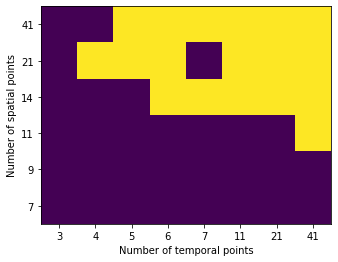

In [27]:
data_loop = [3,4,5,6,7,11,21,41]
plt.imshow(np.array([error_40,error_20,error_14,error_10,error_9,error_7]),aspect=1)
plt.yticks([0,1,2,3,4,5],['41', '21', '14', '11','9','7'])
plt.xticks([0,1,2,3,4,5,6,7],data_loop)
plt.xlabel('Number of temporal points')
plt.ylabel('Number of spatial points')
plt.savefig('no_noise_artificial.pdf')

## Spatial and temporal for noise = 2%

In [28]:
mask = np.array([False,False,True,True,True,False,False,False,False])

In [29]:
ref = np.array([0,0,0.2,0.02,0.02,0,0,0,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0,0,0,0]) + 10**-9*np.ones(9)

In [38]:
data_loop = [3,4,5,6,7,11,21,41]
error_7_n2 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/2_noise_x07/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_7_n2.append(1) 
    else: 
        error_7_n2.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong
wrong
correct
wrong
wrong


In [37]:
data_loop = [3,4, 5, 6,7,11,21,41]
error_10_n2 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/2_noise_x11/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_10_n2.append(1) 
    else: 
        error_10_n2.append(0); 
        print('wrong')

wrong
correct
wrong
wrong
wrong
correct
correct
correct


In [36]:
data_loop = [3,4, 5, 6,7,11,21,41]
error_10_n2 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/2_noise_x11/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_10_n2.append(1) 
    else: 
        error_10_n2.append(0); 
        print('wrong')

wrong
correct
wrong
wrong
wrong
correct
correct
correct


In [35]:
data_loop = [3,4,5,6,7,11,21,41]
error_14_n2 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/2_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_14_n2.append(1) 
    else: 
        error_14_n2.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong
correct
correct
wrong
correct


In [34]:
data_loop = [3,4,5,6,7,11,21,41]
error_2_n2 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/2_noise_x21/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_2_n2.append(1) 
    else: 
        error_2_n2.append(0); 
        print('wrong')

wrong
correct
wrong
wrong
wrong
correct
correct
correct


In [33]:
data_loop = [3,4,5,6,7,11,21,41]
error_41_n2 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/2_noise_x41/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_41_n2.append(1) 
    else: 
        error_41_n2.append(0); 
        print('wrong')

correct
correct
correct
wrong
correct
correct
correct
correct


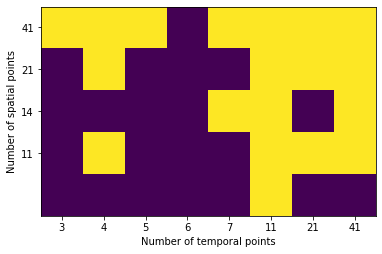

In [41]:
data_loop = [3,4,5,6,7,11,21,41]
plt.imshow(np.array([error_41_n2,error_2_n2,error_14_n2,error_10_n2,error_7_n2]),aspect=1)
plt.yticks([0,1,2,3],['41', '21', '14','11'])
plt.xticks([0,1,2,3,4,5,6,7],data_loop)
plt.xlabel('Number of temporal points')
plt.ylabel('Number of spatial points')
plt.savefig('2_noise_artificial.pdf')
plt.show()

## Spatial and temporal for noise = 20%

In [5]:
mask = np.array([False,False,True,True,True,False,False,False,False])

In [6]:
ref = np.array([0,0,0.2,0.02,0.02,0,0,0,0]) 
ref_b =  np.array([0,0,0.2,0.02,0.02,0,0,0,0]) + 10**-9*np.ones(9)

In [42]:
data_loop = [3,4,5,6,7,11,21,41]
error_07_n20 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/20_noise_x07/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_07_n20.append(1) 
    else: 
        error_07_n20.append(0); 
        print('wrong')

KeyError: 'unscaled_coeffs_output_0_coeff_0'

In [21]:
data_loop = [3,4, 5, 6,7,11,21,41]
error_10_n20 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/20_noise_x10/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_10_n20.append(1) 
    else: 
        error_10_n20.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong
wrong
wrong
wrong
correct


In [22]:

data_loop = [3,4,5,6,7,11,21,41]
error_14_n20 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/20_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_14_n20.append(1) 
    else: 
        error_14_n20.append(0); 
        print('wrong')

correct
wrong
wrong
wrong
correct
correct
correct
correct


In [23]:
data_loop = [3,4,5,6,7,11,21,41]
error_20_n20 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/20_noise_x21/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_20_n20.append(1) 
    else: 
        error_20_n20.append(0); 
        print('wrong')

correct
correct
correct
correct
correct
correct
correct
correct


In [24]:
data_loop = [3,4,5,6,7,11,21,41]
error_41_n20 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/20_noise_x41/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_41_n20.append(1) 
    else: 
        error_41_n20.append(0); 
        print('wrong')

wrong
correct
correct
correct
correct
correct
correct
correct


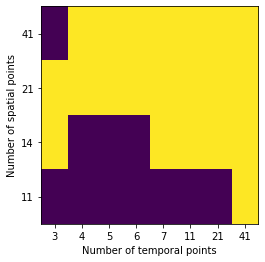

In [26]:
data_loop = [3,4,5,6,7,11,21,41]
plt.imshow(np.array([error_41_n20,error_20_n20,error_14_n20,error_10_n20]),aspect=2)
plt.yticks([0,1,2,3],['41', '21', '14','11'])
plt.xticks([0,1,2,3,4,5,6,7],data_loop)
plt.xlabel('Number of temporal points')
plt.ylabel('Number of spatial points')
plt.savefig('20_noise_artificial.pdf')
plt.show()

## Impact of noise

In [29]:
mask = np.array([False,False,True,True,True,False,False,False,False])

In [50]:
data_loop = [3,4,5,6,7,11,21,41]
error_14_n20 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/20_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.ma.allequal(xi.astype(bool), mask) == True:
        print('correct')
        error_14_n20.append(1) 
    else: 
        error_14_n20.append(0); 
        print('wrong')

correct
wrong
wrong
wrong
correct
correct
correct
correct


In [55]:
data_loop = [3,4,5,6,7,11,21,41]
error_14_n40 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/40_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.count_nonzero(xi) == 3:
        print('correct')
        error_14_n40.append(0)
    else: 
        error_14_n40.append(1); 
        print('wrong')

wrong
wrong
wrong
correct
correct
correct
correct
correct


In [42]:
data_loop = [3,4,5,6,7, 11,21,41]
error_14_n60 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/60_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.count_nonzero(xi) == 3:
        print('correct')
        error_14_n60.append(1) 
    else: 
        error_14_n60.append(0); 
        print('wrong')

wrong
wrong
wrong
correct
correct
correct
correct
correct


In [8]:
data_loop = [3,4,5,6,7,11,21,41]
error_14_n80 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/80_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.count_nonzero(xi) == 3:
        k = np.sum(np.abs((xi-ref)/ref_b))
        error_14_n80.append(1) 
    else: 
        error_14_n80.append(0); 
        print('wrong')

wrong
wrong
wrong


In [41]:
data_loop = [3,4,5,6,7,11,21,41]
error_14_n100 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/100_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.count_nonzero(xi) == 3:
        error_14_n100.append(1) 
    else: 
        error_14_n100.append(0); 
        print('wrong')

wrong
wrong
wrong


In [47]:
data_loop = [3,4,5,6,7,11,21,41]
error_14_n140 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/140_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.count_nonzero(xi) == 3:
        k = np.sum(np.abs((xi-ref)/ref_b))
        error_14_n140.append(1) 
    else: 
        error_14_n140.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong


In [37]:
data_loop = [3,4,5,6,7,11,21,41]
error_14_n160 = []
for idx in data_loop:
    df = load_tensorboard('final_runs/160_noise_x14/'+str(idx)+'/')
    xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-1]
    if np.count_nonzero(xi) == 3:
        print('correct')
        error_14_n160.append(1) 
    else: 
        error_14_n160.append(0); 
        print('wrong')

wrong
wrong
wrong
wrong
wrong
wrong
wrong
correct


In [44]:
error_14_n140

[1, 1, 1, 1, 0.6727900270887213, 0.7317993310839835, 1, 0.41101957227651154]

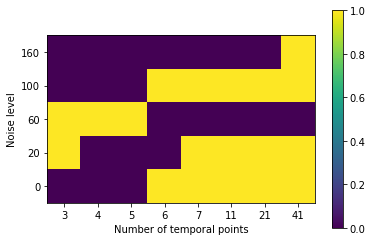

In [62]:
data_loop = [3,4,5,6,7,11,21,41]
plt.imshow(np.array([error_14_n160,error_14_n100,error_14_n40,error_14_n20,error_14]))
plt.yticks([0,1,2,3,4],['160','100','60','20','0'])
plt.xticks([0,1,2,3,4,5,6,7],data_loop)
plt.xlabel('Number of temporal points')
plt.ylabel('Noise level')
plt.colorbar()
plt.show()

(0.0, 0.2)

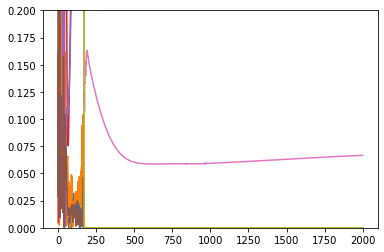

In [143]:
df = load_tensorboard('final_runs/no_noise_x41/'+str(4)+'/')

plt.plot(np.abs(np.array([df.loc[:,'coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)])).T)
plt.ylim(0,0.2)

In [138]:
xi = np.abs(np.array([df.loc[:,'unscaled_coeffs_output_0_coeff_'+str(i)] for i in np.arange(0,9)]))[:,-100]
xi

array([0.00000000e+00, 0.00000000e+00, 1.80436134e-01, 1.89559814e-02,
       2.00676881e-02, 0.00000000e+00, 6.89391309e-05, 0.00000000e+00,
       0.00000000e+00])

## Load model

In [30]:
data = loadmat('Diffusion_2D_space81.mat')
data = np.real(data['Expression1']).reshape((81,81,81,4))[:,:,:,3]
down_data= np.take(np.take(np.take(data,np.arange(0,data.shape[0],1),axis=0),np.arange(0,data.shape[1],1),axis=1),np.arange(0,data.shape[2],1),axis=2)

print("Dowmsampled shape:",down_data.shape)

Dowmsampled shape: (81, 81, 81)


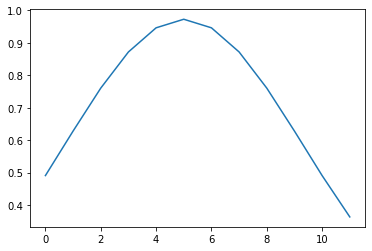

In [19]:
plt.plot(down_data[41,35:47,0])

In [31]:
width, width_2, steps = down_data.shape
x_arr = np.linspace(0,1,width)
y_arr = np.linspace(0,1,width_2)
t_arr = np.linspace(0,1,steps)
x_grid, y_grid, t_grid = np.meshgrid(x_arr, y_arr, t_arr, indexing='ij')

In [32]:
np.max(down_data)

1.0

In [33]:
X = np.transpose((t_grid.flatten(), x_grid.flatten(), y_grid.flatten()))
y = np.float32(down_data.reshape((down_data.size, 1)))

In [36]:
noise_level = 0.20
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

In [38]:
10**(-4)/np.var(y_noisy)

0.07955831137377294

In [7]:
number_of_samples = 5000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y[idx, :][:number_of_samples], dtype=torch.float32)

In [8]:
network = NN(3, [40, 40, 40, 40], 1)
library = Library2D_third(poly_order=0) 
estimator = Threshold(0.05) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 
constraint = LeastSquares() 

Now we instantiate the model and select the optimizer 

In [9]:
model = DeepMoD(network, library, estimator, constraint)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=2e-3) 


Now we instantiate the model and select the optimizer 

In [10]:
model = DeepMoD(network, library, estimator, constraint)
model.load_state_dict(torch.load('runs/noise_20/model.pt'))
model.eval()

DeepMoD(
  (func_approx): NN(
    (network): Sequential(
      (0): Linear(in_features=3, out_features=40, bias=True)
      (1): Tanh()
      (2): Linear(in_features=40, out_features=40, bias=True)
      (3): Tanh()
      (4): Linear(in_features=40, out_features=40, bias=True)
      (5): Tanh()
      (6): Linear(in_features=40, out_features=40, bias=True)
      (7): Tanh()
      (8): Linear(in_features=40, out_features=1, bias=True)
    )
  )
  (library): Library2D_third()
  (sparse_estimator): Threshold()
  (constraint): LeastSquares()
)

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data:
* The directory where the tensorboard file is written (log_dir)
* The ratio of train/test set used (split)
* The maximum number of iterations performed (max_iterations)
* The absolute change in L1 norm considered converged (delta)
* The amount of epochs over which the absolute change in L1 norm is calculated (patience)

Sparsity masks provide the active and non-active terms in the PDE:

In [10]:
sol = model(torch.tensor(X, dtype=torch.float32))[0].reshape((width,width_2,steps)).detach().numpy()

In [11]:
ux = model(torch.tensor(X, dtype=torch.float32))[2][0][:,1].reshape((width,width_2,steps)).detach().numpy()
uy = model(torch.tensor(X, dtype=torch.float32))[2][0][:,2].reshape((width,width_2,steps)).detach().numpy()

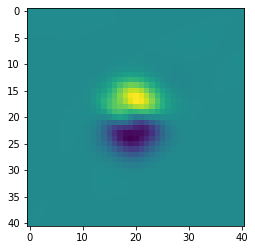

In [17]:
plt.imshow(ux[:,:,3])

In [12]:
ut = model(torch.tensor(X, dtype=torch.float32))[1][0].reshape((width,width_2,steps)).detach().numpy()

In [ ]:
uxx = model(torch.tensor(X, dtype=torch.float32))[2][0][:,3].reshape((width,width_2,steps)).detach().numpy()
uyy = model(torch.tensor(X, dtype=torch.float32))[2][0][:,4].reshape((width,width_2,steps)).detach().numpy()

In [23]:
import pysindy as ps

In [47]:
fd_spline = ps.SINDyDerivative(kind='spline', s=1e-2)
fd_spectral = ps.SINDyDerivative(kind='spectral')
fd_sg = ps.SINDyDerivative(kind='savitzky_golay', left=0.5, right=0.5, order=3)

In [ ]:
y = down_data[7,5,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'bo--')
plt.plot(t,ut[7,5,:]*np.max(down_data)/np.max(t_grid),'b', label='y = 12',linewidth=3)
y = down_data[7,10,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'go--')
plt.plot(t,ut[7,10,:]*np.max(down_data)/np.max(t_grid),'g', label='y = 6',linewidth=3)
y = down_data[7,15,:]
t = t_arr
plt.plot(t,fd_sg(y,t), 'ro--')
plt.plot(t,ut[7,15,:]*np.max(down_data)/np.max(t_grid),'r', label='y = 18',linewidth=3)
plt.legend()

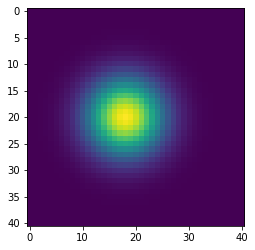

In [16]:
plt.imshow(down_data[:,:,10])


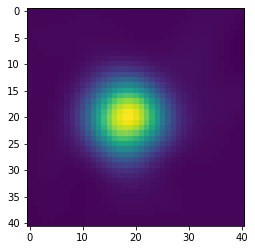

In [17]:
plt.imshow(sol[:,:,10])

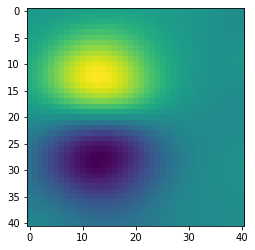

In [40]:
plt.imshow(ux[:,:,40])

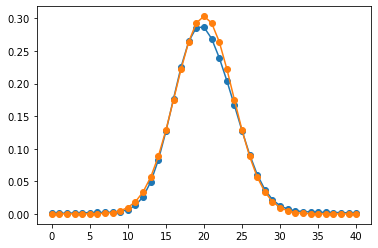

In [37]:
plt.plot(sol[:,20,5],'o-')
plt.plot(down_data[:,20,5],'o-')

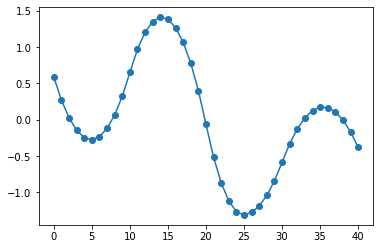

In [48]:
plt.plot(fd_spline(sol[:,20,5],x),'o-')

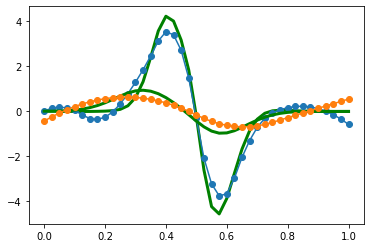

In [52]:
plt.plot(x,uy[20,:,2]*np.max(down_data)/np.max(y_grid),'g', label='x = 5',linewidth=3)
plt.plot(x,fd_spline(sol[20,:,2],x),'o-')

plt.plot(x,uy[20,:,10]*np.max(down_data)/np.max(y_grid),'g', label='x = 5',linewidth=3)
plt.plot(x,fd_spline(sol[20,:,10],x),'o-')

In [ ]:
plt.plot(x,uy[20,:,2]*np.max(down_data)/np.max(y_grid),'g', label='x = 5',linewidth=3)
plt.plot(x,fd_spline(sol[20,:,2],x),'o-')

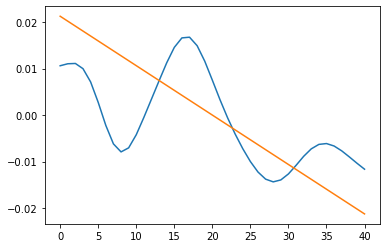

In [33]:
plt.plot(ux[:,5,10])
plt.plot(fd_spline(down_data[:,5,10],x))

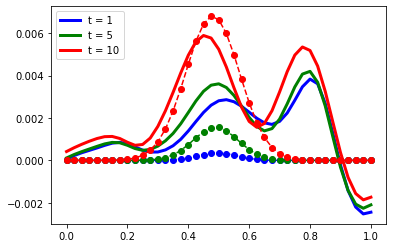

In [14]:
y = down_data[10,:,1]
x = y_arr
plt.plot(x,y, 'bo--')
plt.plot(x,sol[10,:,1]*np.max(down_data),'b', label='t = 1',linewidth=3)
y = down_data[10,:,2]
x = y_arr
plt.plot(x,y, 'go--')
plt.plot(x,sol[10,:,2]*np.max(down_data),'g', label='t = 5',linewidth=3)
y = down_data[10,:,4]
x = y_arr
plt.plot(x,y, 'ro--')
plt.plot(x,sol[10,:,4]*np.max(down_data),'r', label='t = 10',linewidth=3)
plt.legend()

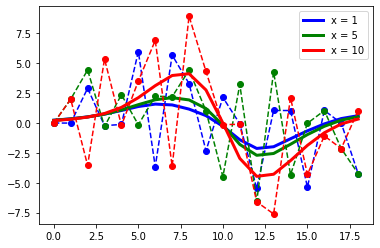

In [17]:
y = down_data[7,:,1]
x = y_arr
plt.plot(x,fd_sg(y,x), 'bo--')
plt.plot(x,uy[7,:,1]*np.max(down_data)/np.max(y_grid),'b', label='x = 1',linewidth=3)
y = down_data[7,:,2]
x = y_arr
plt.plot(x,fd_sg(y,x), 'go--')
plt.plot(x,uy[7,:,2]*np.max(down_data)/np.max(y_grid),'g', label='x = 5',linewidth=3)
y = down_data[7,:,4]
x = y_arr
plt.plot(x,fd_sg(y,x), 'ro--')
plt.plot(x,uy[7,:,4]*np.max(down_data)/np.max(y_grid),'r', label='x = 10',linewidth=3)
plt.legend()

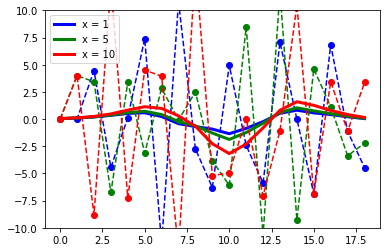

In [39]:
y = down_data[7,:,1]
x = y_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'bo--')
plt.plot(x,uyy[7,:,1]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'b',label='x = 1',linewidth=3)
y = down_data[7,:,2]
x = y_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'go--')
plt.plot(x,uyy[7,:,2]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'g',label='x = 5',linewidth=3)
y = down_data[7,:,4]
x = y_arr
plt.plot(x,fd_sg(fd_sg(y,x)), 'ro--')
plt.plot(x,uyy[7,:,4]*np.max(down_data)/(np.max(y_grid)*np.max(y_grid)),'r',label='x = 10',linewidth=3)
plt.ylim(-10,10)
plt.legend()

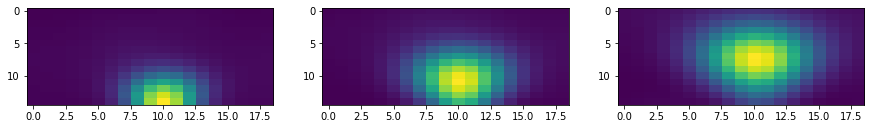

In [42]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3, 1)
plt.imshow(sol[:,:,1], aspect=0.5)

plt.subplot(1,3, 2)
plt.imshow(sol[:,:,10], aspect=0.5)

plt.subplot(1,3, 3)
plt.imshow(sol[:,:,19], aspect=0.5)


#plt.savefig('reconstruction.pdf')